<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-pakgs" data-toc-modified-id="import-pakgs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import pakgs</a></span></li><li><span><a href="#functions-define" data-toc-modified-id="functions-define-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>functions define</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#Model-define" data-toc-modified-id="Model-define-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model define</a></span><ul class="toc-item"><li><span><a href="#Start" data-toc-modified-id="Start-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Start</a></span></li></ul></li></ul></div>

# import pakgs

In [1]:
from fastai.vision.all import *

In [2]:
import timm
from wwf.vision.timm import *

In [3]:
import fastai
fastai.__version__

'2.1.10'

In [4]:
# Python library for image augmentation
import albumentations as A

In [5]:
timm.list_models('*', pretrained=True)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficie

# functions define

In [6]:
'''AlbumentationsTransform will perform different transforms over both
   the training and validation datasets ''' 
class AlbumentationsTransform(RandTransform):
    
    '''split_idx is None, which allows for us to say when we're setting our split_idx.
       We set an order to 2 which means any resize operations are done first before our new transform. '''
    split_idx, order = None, 2
    
    def __init__(self, train_aug, valid_aug): store_attr()
    
    # Inherit from RandTransform, allows for us to set that split_idx in our before_call.
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    # If split_idx is 0, run the trainining augmentation, otherwise run the validation augmentation. 
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [7]:
def get_train_aug(size): 
    
    return A.Compose([
            # allows to combine RandomCrop and RandomScale
#             A.RandomResizedCrop(size,size),
            
            # Transpose the input by swapping rows and columns.
#             A.Transpose(p=0.5),
        
            # Flip the input horizontally around the y-axis.
            A.HorizontalFlip(p=0.5),
        
            # Flip the input horizontally around the x-axis.
#             A.VerticalFlip(p=0.5),
        
            # Randomly apply affine transforms: translate, scale and rotate the input.
            A.ShiftScaleRotate(p=0.5),
        
            # Randomly change hue, saturation and value of the input image.
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        
            # Randomly change brightness and contrast of the input image.
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5)
        
            # CoarseDropout of the rectangular regions in the image.
#             A.CoarseDropout(p=0.5),
        
            # CoarseDropout of the square regions in the image.
#             A.Cutout(p=0.5) 
    ])

def get_valid_aug(size): 
    
    return A.Compose([
    # Crop the central part of the input.   
#     A.CenterCrop(size, size, p=1.),
    
    # Resize the input to the given height and width.    
    A.Resize(size,size)], p=1.)

# Dataloader

In [8]:
'''The first step item_tfms resizes all the images to the same size (this happens on the CPU) 
   and then batch_tfms happens on the GPU for the entire batch of images. '''
resolution = 224
bs=16

# Transforms we need to do for each image in the dataset
item_tfms = [Resize(resolution), AlbumentationsTransform(get_train_aug(resolution), get_valid_aug(resolution))]

# Transforms that can take place on a batch of images
batch_tfms = [Normalize.from_stats(*imagenet_stats)]


In [9]:
csv_file = 'training_bal.csv'
df_in = pd.read_csv(csv_file,index_col=0)

In [10]:
df_in.head()

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path,valid_bal
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",1,5776db0cec75,5776db0cec75_study,0,1,0,0,F:\Projects\Kaggle_Siim\Data\train\5776db0cec75\81456c9c5423\000a312787f2.dcm,0
1,000c3a3f293f_image,NaN,0,ff0879eb20ed,ff0879eb20ed_study,1,0,0,0,F:\Projects\Kaggle_Siim\Data\train\ff0879eb20ed\d8a644cc4f93\000c3a3f293f.dcm,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",1,9d514ce429a7,9d514ce429a7_study,0,1,0,0,F:\Projects\Kaggle_Siim\Data\train\9d514ce429a7\22897cd1daa0\0012ff7358bc.dcm,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",3,28dddc8559b2,28dddc8559b2_study,0,0,0,1,F:\Projects\Kaggle_Siim\Data\train\28dddc8559b2\4d47bc042ee6\001398f4ff4f.dcm,0
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",1,dfd9fdd85a3e,dfd9fdd85a3e_study,0,1,0,0,F:\Projects\Kaggle_Siim\Data\train\dfd9fdd85a3e\49170afa4f27\001bd15d1891.dcm,0


In [11]:
df=df_in[['id_x','label','valid_bal','path']]

In [12]:
df.head()

,id_x,label,valid_bal,path
0,000a312787f2_image,1,0,F:\Projects\Kaggle_Siim\Data\train\5776db0cec75\81456c9c5423\000a312787f2.dcm
1,000c3a3f293f_image,0,0,F:\Projects\Kaggle_Siim\Data\train\ff0879eb20ed\d8a644cc4f93\000c3a3f293f.dcm
2,0012ff7358bc_image,1,0,F:\Projects\Kaggle_Siim\Data\train\9d514ce429a7\22897cd1daa0\0012ff7358bc.dcm
3,001398f4ff4f_image,3,0,F:\Projects\Kaggle_Siim\Data\train\28dddc8559b2\4d47bc042ee6\001398f4ff4f.dcm
4,001bd15d1891_image,1,0,F:\Projects\Kaggle_Siim\Data\train\dfd9fdd85a3e\49170afa4f27\001bd15d1891.dcm


<AxesSubplot:>

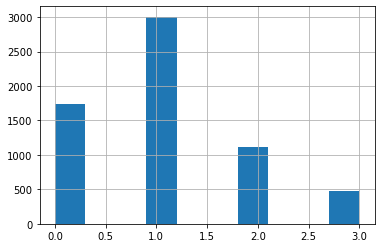

In [13]:
df['label'].hist()

In [20]:
df['bi_label'] = df.apply(lambda x: 0 if x['label'] == 0 else 1, axis = 1)

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


valid_bal
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bi_label, dtype: object

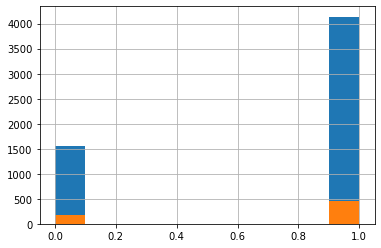

In [22]:
df.groupby('valid_bal').bi_label.hist()

In [22]:
os.path.join(df.loc[0,'path'].split('\\')[-2],df.loc[0,'path'].split('\\')[-1])

'COVID\\COVID-1.png'

In [24]:
df['path'] = df.apply(lambda x:os.path.join(x['path'].split('\\')[-2],x['path'].split('\\')[-1]),axis=1)

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df.head()

,path,class_num,valid
0,COVID\COVID-1.png,1,0
1,COVID\COVID-10.png,1,0
2,COVID\COVID-100.png,1,0
3,COVID\COVID-1000.png,1,0
4,COVID\COVID-1001.png,1,0


In [26]:
data_folder = r'E:\Xing\Kaggle_covid19\archive\COVID-19_Radiography_Dataset\Data'
dls = ImageDataLoaders.from_df(df, path=data_folder, 
                               label_col='class_num', 
                               valid_col='valid', 
                               item_tfms=item_tfms, batch_tfms=batch_tfms, 
                               bs = bs,
                               num_workers=0)

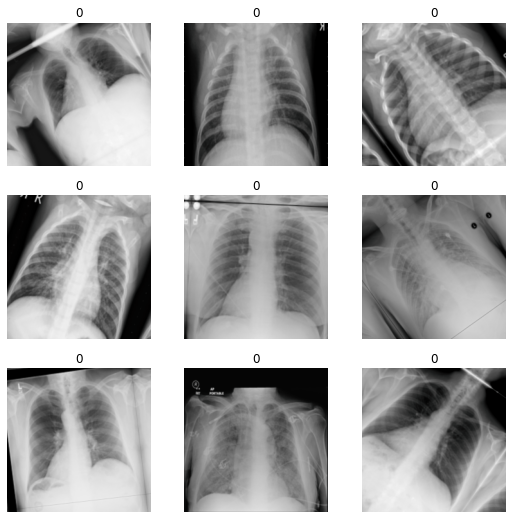

In [28]:
dls.show_batch()

In [19]:
# learn = cnn_learner(dls, models.resnet18, metrics=error_rate)

# Model define

In [23]:
learn = timm_learner(dls, 'efficientnet_b2', 
                     loss_func=CrossEntropyLossFlat(),
                     metrics=[error_rate, accuracy] 
                    )

In [32]:
class CSPNetModel(nn.Module):
    
    def __init__(self, num_classes=2, model_name='cspresnext50', pretrained=True):
        super(CSPNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head.fc = nn.Linear(self.model.head.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
model = CSPNetModel()

In [21]:
class EFFNetModel(nn.Module):
    
    def __init__(self, num_classes=2, model_name='efficientnet_b2', pretrained=True):
        super(EFFNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
#         self.model.head.fc = nn.Linear(self.model.head.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
model = EFFNetModel()

## Start

In [34]:
# learn = cnn_learner(dls, models., metrics=error_rate)
# model = timm.create_model('efficientnet_b3',pretrained = True)
model = timm.create_model('gluon_resnet34_v1b',pretrained = True)
# model = timm.create_model('vgg16_bn',pretrained = True)
learn = Learner(dls, model, metrics=[error_rate,accuracy])

Downloading: "https://github.com/rwightman/pytorch-pretrained-gluonresnet/releases/download/v0.1/gluon_resnet34_v1b-c6d82d59.pth" to C:\Users\echang/.cache\torch\hub\checkpoints\gluon_resnet34_v1b-c6d82d59.pth


In [35]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.726342,0.465724,0.176276,0.823724,03:26


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.296540,0.203255,0.071361,0.928639,03:27


SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=6.309573450380412e-07)

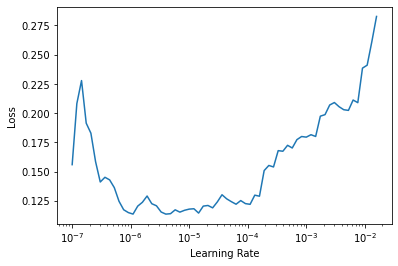

In [31]:
learn.lr_find()

In [22]:
learn.fine_tune(40,0.0001)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.643861,0.665340,0.407059,0.592941,05:17


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.628551,0.663508,0.390588,0.609412,04:34
1,0.597910,0.666104,0.378824,0.621176,04:33
2,0.573703,0.677786,0.374118,0.625882,04:33
3,0.563395,0.713810,0.357647,0.642353,04:34
4,0.538870,0.712491,0.369412,0.630588,04:34
5,0.507441,0.758423,0.374118,0.625882,04:33
6,0.462247,0.815337,0.348235,0.651765,04:34
7,0.432284,0.916376,0.371765,0.628235,04:34
8,0.416488,0.959568,0.390588,0.609412,04:34
9,0.382394,1.057732,0.407059,0.592941,04:34


In [ ]:
learn.fit

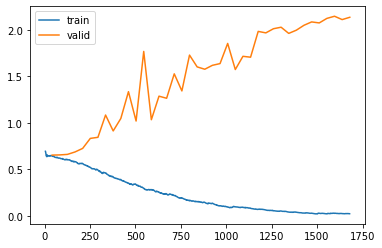

In [21]:
# Plot training and validation losses.
learn.recorder.plot_loss()

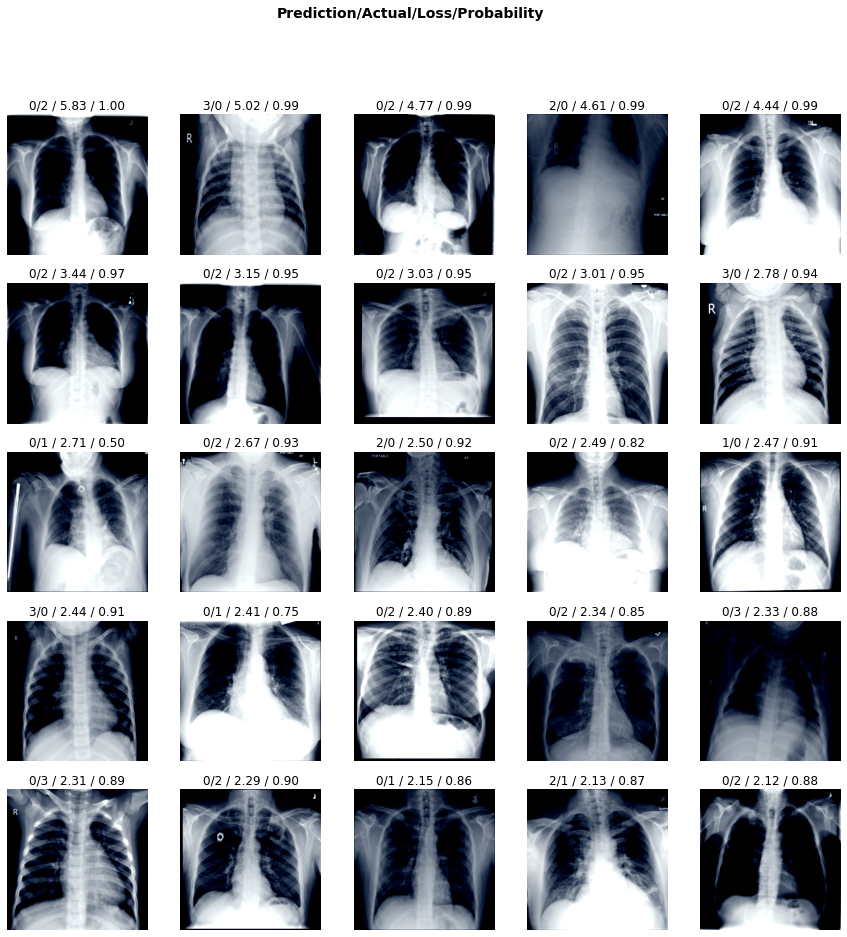

In [33]:
# Interpretation methods for classification models.
interp = ClassificationInterpretation.from_learner(learn)

# Show images in top_losses along with their prediction, actual, loss, and probability of actual class.
interp.plot_top_losses(25, nrows=5)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=9.12010818865383e-07)

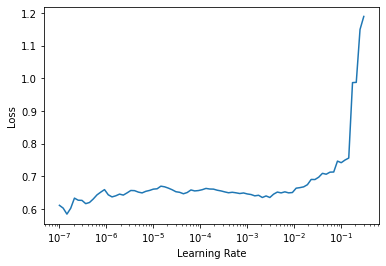

In [41]:
learn.lr_find()

In [42]:
learn.fine_tune(40,1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.636520,0.633755,0.362353,0.637647,04:23


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.625791,0.631509,0.371765,0.628235,04:22
1,0.628416,0.631843,0.364706,0.635294,04:25
2,0.635580,0.630956,0.357647,0.642353,04:26
3,0.623891,0.631105,0.352941,0.647059,04:33
4,0.630252,0.631526,0.352941,0.647059,04:23
5,0.632385,0.634032,0.355294,0.644706,04:30
6,0.628021,0.633789,0.336471,0.663529,04:31
7,0.623866,0.628539,0.317647,0.682353,04:25
8,0.622761,0.628189,0.331765,0.668235,04:27
9,0.614247,0.638731,0.338824,0.661176,04:25


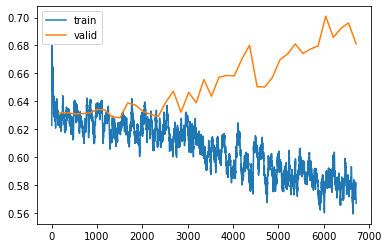

In [43]:
# Plot training and validation losses.
learn.recorder.plot_loss()

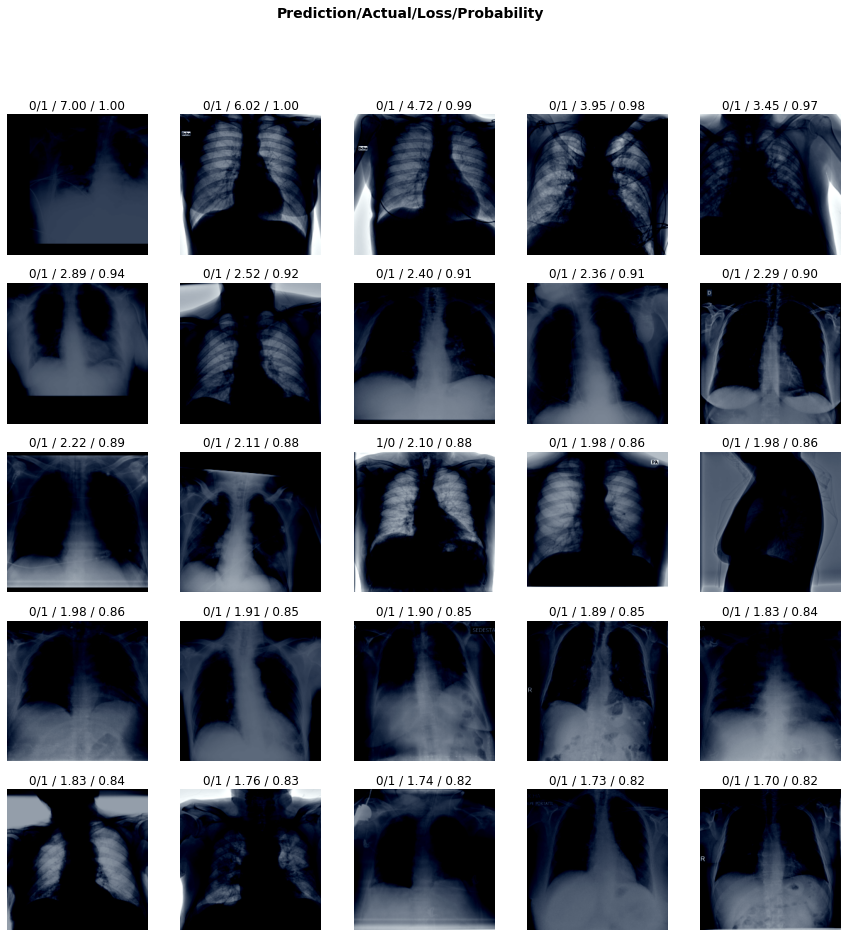

In [44]:
# Interpretation methods for classification models.
interp = ClassificationInterpretation.from_learner(learn)

# Show images in top_losses along with their prediction, actual, loss, and probability of actual class.
interp.plot_top_losses(25, nrows=5)